In [1]:
#Imports Libraries we will use
import numpy as np
import matplotlib.pyplot as plt

#Increases the tick labelsize on plots for the entire document
#Do not run this again, because it will increase label sizes further!
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

In [2]:
def BSplineRec(j, p, Xi, x):
    """Calculates the value of the B-Spline B_{j,p,Xi}(x)

    Args:
        j (int): index of the Spline 1 <= j <= len(Xi)-p-1
        p (int): degree of the Splines
        Xi (1D numpy.array): knot sequence
        x (float): point where the Spline will be evaluated

    Returns:
        y (float): B_{j,p,Xi}(x)
    """
    
    #restricting Xi to only the knots we need for our calculation
    #i.e., the truncated knot vector
    knots = Xi[j-1:j+p+1]

    #The fact that we take our right-most interval to be closed
    #instead of half-open creates a special case, which the code
    #below cannot handle. Specifically, our right-most Spline
    #could be discontinous at Xi[-1]. In this case the code below
    #returns 0 when it should return 1. 
    #To avoid this we first check:
    
    if knots[0]<knots[1]==knots[-1]==Xi[-1]==x:
        return 1

    #Now for the general case:

    #creating some dummy variables
    PrevSplines = np.zeros(len(knots)-1)
    k = 1
    
    #initial evaluations for p=0
    for i in range(len(knots)-1):
        if knots[i] <= x < knots[i+1]:
            PrevSplines[i] = 1
            #since only one of the values is 1 we can end the loop now
            break

    while k <= p:
        #this loop calculates the values of the B-Splines of 
        #degree k at x and writes them into NextSplines
        
        #Creating a new array that has 1 entry less than the old one,
        #because there's 1 fewer B-Spline for each degree.
        NextSplines = np.zeros(PrevSplines.size -1)

        
        for l in range(NextSplines.size):
            #Calculating B_{j+l,k,Xi}(x)
            
            #fractions with denominator 0 have value 0.
            if knots[l+k] == knots[l]:
                left_term = 0
            else:
                left_term = (x-knots[l])/(knots[l+k]-knots[l])*PrevSplines[l]

            if knots[l+k+1] == knots[l+1]:
                right_term = 0
            else:
                right_term = (knots[l+k+1]-x)/(knots[l+k+1]-knots[l+1])*PrevSplines[l+1]

            #adding the new values to the array
            NextSplines[l] = left_term + right_term
        #replacing the old array with the new
        PrevSplines = NextSplines
        k+=1

    #the array now only has one element, which is our desired result.
    #we convert our final result to float instead of np.float64
    y = float(PrevSplines[0])

    return y

In [3]:
def BSplineDerivative(j, p, Xi, x, k):
    """Calculates the k-th derivative of the B-Spline B_{j,p,Xi}(x)

    Args:
        j (int): index of the Spline 1 <= j <= len(Xi)-p-1
        p (int): degree of the Splines
        Xi (1D numpy.array): knot sequence
        x (float): point where the Spline will be evaluated
        k (int): Order of derivative 0 <= k
    Returns:
        y (float): D^kB_{j,p,Xi}(x)
    """

    #If we take more derivatives than the polynomial has degrees,
    #the result is 0
    if p<k:
        y = 0

    #If we take no derivatives just evaluate the function
    elif k==0:
        y = BSplineRec(j, p, Xi, x)

    
    #Here we recursively call this function. This is inefficient
    #for large k, but for us k will be at most 2, so this is not
    #a problem.
    else:
        left_term = 0
        right_term = 0

        #We use the differentiation formula.
        if Xi[j+p-1] != Xi[j-1]:
            left_term = BSplineDerivative(j, p-1, Xi, x, k-1)/(Xi[j+p-1]-Xi[j-1])

        if Xi[j+p] != Xi[j]:
            right_term = (-1)*BSplineDerivative(j+1, p-1, Xi, x, k-1)/(Xi[j+p]-Xi[j])
        
        y = p*(left_term+right_term)

    return y

In [4]:
def CubicSplineCoeff(x, y):
    """Calculates the coefficients of a Cubic Spline S which interpolates
    the points (x_0, y_0), ... , (x_{m-1}, y_{m-1}).

    Args:
        x (1D np.array): x-values of the points (distinct)
        y (1D np.array): y-values of the points (same length as x)

    Returns:
        c (1D np.array): Coefficients of the desired function in the cubic B-Spline basis
    """

    m = np.size(x)
    
    #define knot sequence Xi. We increase the multiplicity of each endpoint to 4.
    temp = np.append(np.full(3, x[0]), x)
    Xi = np.append(temp, np.full(3, x[-1]))
    
    #empty matrix we will fill with equations
    A = np.zeros((m+2,m+2))

    #First, we write the m lines associated with the equations S(x_i)=y_i into A
    for i in range(m):
        #Note: BSplineRec needs 1 <= j <= len(Xi)-p-1, 
        #but matrix indexes start at 0!
        for j in range(i+1, i+4):
            A[i,j-1] = BSplineRec(j, 3, Xi, x[i])


    #The last 2 lines of the matrix represent 
    #the free boundary conditions S''(x_0)=0 and S''(x_{m-1})=0
    for j in range(1,4):
        A[-2,j-1] = BSplineDerivative(j, 3, Xi, x[0], 2)
    for j in range(m,m+3):
        A[-1,j-1] = BSplineDerivative(j, 3, Xi, x[-1], 2)
    
    #Now the matrix is finished. 
    #The right side of our system will be:
    Y=np.append(y, np.array([0,0]))

    #Finally, we solve the system Ac=Y
    c = np.linalg.solve(A,Y)

    #Note: c[j] is actually the coefficient of B_{j+1}, because the index 
    #of c starts at 0, while the index of the B-Splines starts at 1!
    return c

In [5]:
def CubicSplineEval(Delta, c, x):
    """Calculates the value of a Cubic Spline S at x 
    given coefficients c in the B-Spline basis.

    Args:
        Delta (1D np.array): break points
        c (1D np.array): coefficients (produced by CubicSplineCoeff)
        x (float): Point to evaluate the spline at

    Returns:
        total (float): S(x)
    """
    
    m = np.size(Delta)
    
    #define knot sequence Xi. We increase the multiplicity of each endpoint to 4.
    temp = np.append(np.full(3, Delta[0]), Delta)
    Xi = np.append(temp, np.full(3, Delta[-1]))

    total = 0
    #multiply the value of each B-Spline at x by 
    #the corresponding coefficient and add them
    #Remember: c[j] is the coefficient of B_{j+1}
    for j in range(1,m+3):
        total += c[j-1]*BSplineRec(j, 3, Xi, x)

    return total

In [6]:
def CubicSplineDif(Delta, c, x):
    """Calculates the derivative of a Cubic Spline S at x 
    given coefficients c in the B-Spline basis.

    Args:
        Delta (1D np.array): break points
        c (1D np.array): coefficients (produced by CubicSplineCoeff)
        x (float): Point to evaluate the derivative at

    Returns:
        total (float): D_+S(x)
    """
    
    m = np.size(Delta)
    
    #define knot sequence Xi. We increase the multiplicity of each endpoint to 4.
    temp = np.append(np.full(3, Delta[0]), Delta)
    Xi = np.append(temp, np.full(3, Delta[-1]))
    
    total = 0
    #Here we use Corollary 2.17 (first equation)
    #Remember: c[j-1] is the coefficient belonging to B_{j,3}
    for j in range(2,m+3):
        total += (c[j-1]-c[j-2])/(Xi[j+2]-Xi[j-1])*BSplineRec(j, 2, Xi, x)

    #we need to multiply by p=3 at the end
    return 3*total

In [7]:
def CubicSplineInt(Delta, c):
    """Calculates the integral of a Cubic Spline S
    from Delta[0] to Delta[-1].

    Args:
        Delta (1D np.array): break points
        c (1D np.array): coefficients (produced by CubicSplineCoeff)

    Returns:
        total (float): Integral of S from Delta[0] to Delta[-1]
    """
    
    m = np.size(Delta)
    
    #define knot sequence Xi. We increase the multiplicity of each endpoint to 4.
    temp = np.append(np.full(3, Delta[0]), Delta)
    Xi = np.append(temp, np.full(3, Delta[-1]))

    total = 0
    #Here we use Corollary 2.17 (second equation)
    for j in range(1,m+3):
        total += c[j-1](Xi[j+3]-Xi[j-1])

    #we need to devide by (p+1) at the end
    return total/4

In [8]:
def PolyInterp(start, end, n, f, x):
    """Evaluates the polynomial interpolant P of f at x.
    Uses n equispaced points in the interval [start, end]

    Args:
        start (float): left endpoint of interval
        end (float): right endpoint of interval 
        n (int): number of equispaced samples
        f (function): Function we want to interpolate
        x (float): point to evaluate the polynomial at

    Returns:
        total (float): P(x)
    """

    #We will use Lagrange Polynomials

    #n equispaced points in the interval [start, end]
    x_samples=np.linspace(start,end,n,endpoint=True)
    
    total=0
    for i in range(n):
        num=1
        denom=1

        #calculate numerator of i-th lagrange polynomial at x
        for j in range(n):
            if j!=i:
                num*=(x-x_samples[j])

        #build denominator of i-th lagrange polynomial
        for j in range(n):
            if j!=i:
                denom*=(x_samples[i]-x_samples[j])

        
        total+=f(x_samples[i])*num/denom

    return total

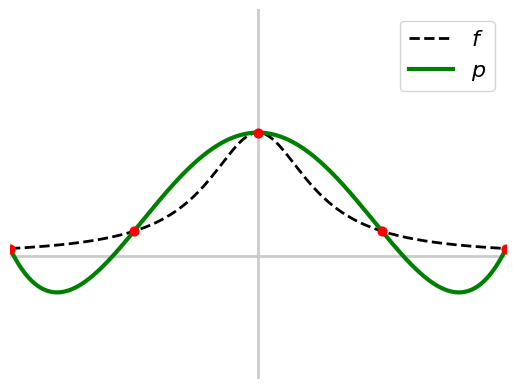

In [9]:
start=2
end=-2

#Setting n=5, 9, 15 yields the left, middle,
#and right plots, respectively.
n=5

#We will evaluate our function at these points
#in order to plot them.
x=np.linspace(start, end, 1000, endpoint=True)

def f(x):
    return 1/(1+4*x**2)


#f and PolyInterp do not accept arrays,
#so we use a loop instead
Y_Poly=[]
Y=[]
for i in x:
    Y_Poly.append(PolyInterp(start, end, n, f, i))
    Y.append(f(i))

x_scatter=np.linspace(start,end,n,endpoint=True)
Y_scatter=[]
for i in x_scatter:
    Y_scatter.append(f(i))


fig,ax=plt.subplots()
plt.scatter(x_scatter,Y_scatter,c="r",s=40,zorder=2)
plt.plot(x,Y,"k",label=r"$f$",zorder=0.1, linestyle='dashed',linewidth=2)
plt.plot(x,Y_Poly,"g",label=r"$p$",zorder=1,linewidth=3)


# Hide all the spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.set_xlim(start, end)
ax.set_ylim(-1, 2)
plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False, bottom=False)

#adds x and y axes
plt.vlines([0], -20, 20, colors='0.8', zorder=0, linewidth=2)
plt.hlines([0], -20, 20, colors='0.8', zorder=0, linewidth=2)

plt.legend(prop={'size': 16})
#plt.savefig("Desktop/Slide3-plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
#Partition of unity test

total = 0
Xi = [0,0,0,0,1,2,3,3,3,3]
for j in range(1,7):
    total += BSplineRec(j, 3, Xi, 2.5)
print(total)

1.0


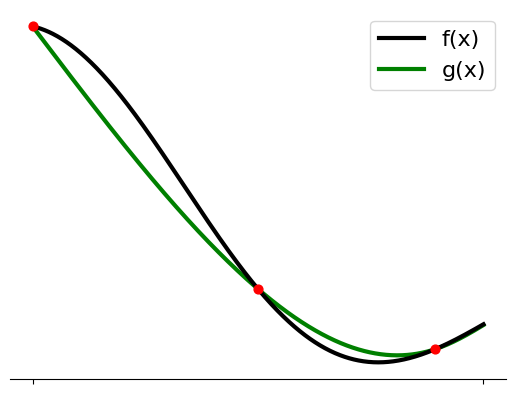

In [11]:
#This plot was not used in the final thesis
#It was used during the presentation, to explain
#the concept of interpolation

def f(x):
    return np.sin(x)/x

#we avoid plugging 0 into either function
x=np.linspace(0.2, 5.8, 1000)

y=f(x)

inx = 2*np.array([0.1,1.5,2.6,3])
iny = f(inx)
c=CubicSplineCoeff(inx, iny)
interp=[]
for i in x:
    interp.append(CubicSplineEval(inx,c,i))

fig,ax=plt.subplots()
#PlottenmitListen
plt.scatter(inx[:-1],iny[:-1],c="r",s=40,zorder=1)
plt.plot(x,y,"k",label="f(x)",zorder=0.5, linewidth=3)
plt.plot(x,interp,"g",label="g(x)",zorder=0, linewidth=3)

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False)
ax.set_xticks(np.array([0.2, 5.8]))

#plt.xlabel("x")
#plt.ylabel("y")
plt.legend(prop={'size': 16})
#plt.savefig("Desktop/Slide2-plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
#Here we define the piecewise polynomial whose plot
#we used to show that the truncated power basis
#is a spanning set

def Piece1(x):
    return -0.5*x+1.75

def Piece2(x):
    return 1.25

def Piece3(x):
    return -(x-3)**2+1.5

def Piece4(x):
    return 0.5*(x-4)+0.5

def PiecewiseExample(x):
    if   0<=  x< 1:
        return Piece1(x)
    elif 1<=  x< 2.5:
        return Piece2(x)
    elif 2.5<=x< 4:
        return Piece3(x)
    elif 4<=  x<=5:
        return Piece4(x)
    else:
        return 0

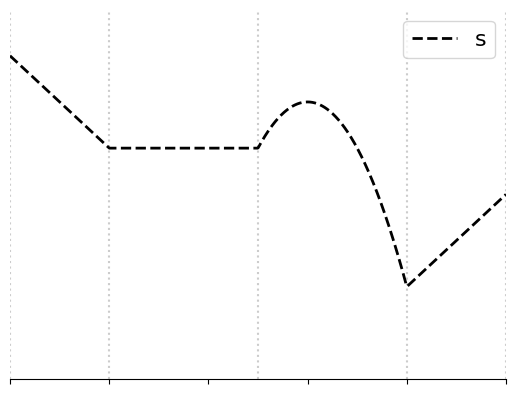

In [13]:
x=np.linspace(0, 5, 1000)

Y_Piecewise=[]
for i in x:
    Y_Piecewise.append(PiecewiseExample(i))






fig,ax=plt.subplots()
plt.plot(x,Y_Piecewise,"k",label="s",zorder=0.1, linestyle='dashed',linewidth=2)

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_xlim(0, 5)
ax.set_ylim(0, 2)
plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False)

plt.vlines([0, 1, 2.5, 4, 5], 0, 2.5, colors='0.8', linestyle='dotted', zorder=0)


#plt.xlabel("x")
#plt.ylabel("y")
plt.legend(prop={'size': 16})
#plt.savefig("Desktop/Slide6-2-plot.png", dpi=300, bbox_inches="tight")
plt.show()

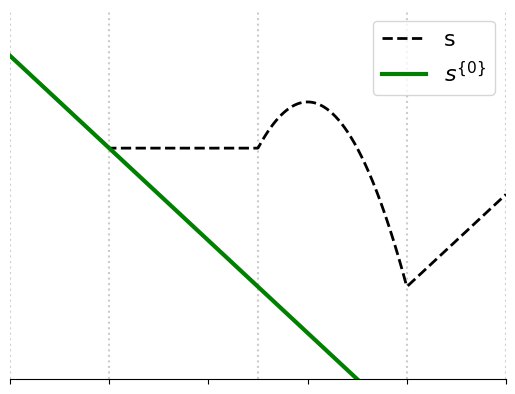

In [14]:
x=np.linspace(0, 5, 1000)
x1=np.linspace(0,5, 1000)
#x1=np.linspace(0,1, 200)
x2=np.linspace(1,2.5,300)
x3=np.linspace(2.5,4,300)
x4=np.linspace(4,5,200)

Y_Piecewise=[]
for i in x:
    Y_Piecewise.append(PiecewiseExample(i))






fig,ax=plt.subplots()
#PlottenmitListen
#plt.plot(x,y,"g",label="f(x)",zorder=0.5)
plt.plot(x,Y_Piecewise,"k",label="s",zorder=0.1, linestyle='dashed',linewidth=2)
plt.plot(x1,Piece1(x1),"g",label=r"$s^{\{0\}}$",zorder=1,linewidth=3)


# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_xlim(0, 5)
ax.set_ylim(0, 2)
plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False)

plt.vlines([0, 1, 2.5, 4, 5], 0, 2.5, colors='0.8', linestyle='dotted', zorder=0)


#plt.xlabel("x")
#plt.ylabel("y")
plt.legend(prop={'size': 16})
#plt.savefig("Desktop/Slide6-3-plot.png", dpi=300, bbox_inches="tight")
plt.show()

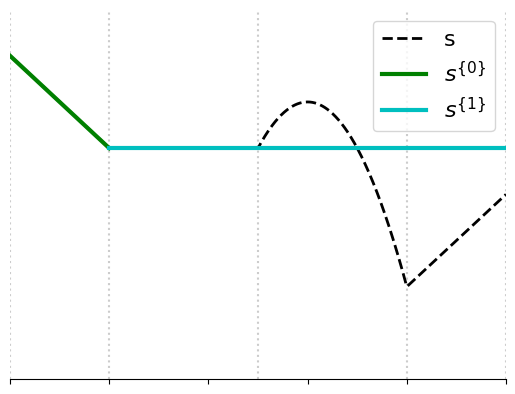

In [15]:
x=np.linspace(0, 5, 1000)
x2=np.linspace(1,5, 800)

x1=np.linspace(0,1, 200)
#x2=np.linspace(1,2.5,300)
x3=np.linspace(2.5,4,300)
x4=np.linspace(4,5,200)

Y_Piecewise=[]
for i in x:
    Y_Piecewise.append(PiecewiseExample(i))






fig,ax=plt.subplots()
#PlottenmitListen
#plt.plot(x,y,"g",label="f(x)",zorder=0.5)
plt.plot(x,Y_Piecewise,"k",label="s",zorder=0.1, linestyle='dashed',linewidth=2)
plt.plot(x1,Piece1(x1),"g",label=r"$s^{\{0\}}$",zorder=1,linewidth=3)

plt.plot(x2,np.full((np.size(x2),), 1.25),"c",label=r"$s^{\{1\}}$",zorder=2,linewidth=3)


# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_xlim(0, 5)
ax.set_ylim(0, 2)
plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False)

plt.vlines([0, 1, 2.5, 4, 5], 0, 2.5, colors='0.8', linestyle='dotted', zorder=0)


#plt.xlabel("x")
#plt.ylabel("y")
plt.legend(prop={'size': 16})
#plt.savefig("Desktop/Slide6-4-plot.png", dpi=300, bbox_inches="tight")
plt.show()

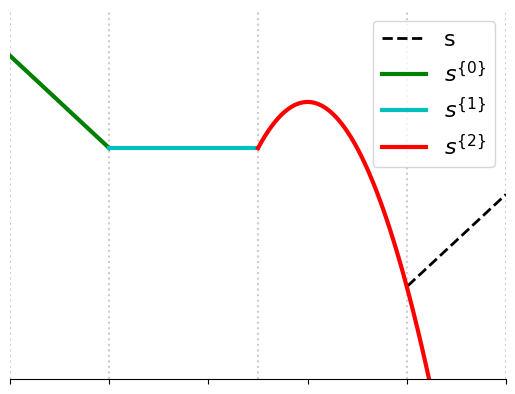

In [16]:
x=np.linspace(0, 5, 1000)
x3=np.linspace(2.5,5, 500)

x1=np.linspace(0,1, 200)
x2=np.linspace(1,2.5,300)
#x3=np.linspace(2.5,4,300)
x4=np.linspace(4,5,200)

Y_Piecewise=[]
for i in x:
    Y_Piecewise.append(PiecewiseExample(i))






fig,ax=plt.subplots()
#PlottenmitListen
#plt.plot(x,y,"g",label="f(x)",zorder=0.5)
plt.plot(x,Y_Piecewise,"k",label="s",zorder=0.1, linestyle='dashed',linewidth=2)
plt.plot(x1,Piece1(x1),"g",label=r"$s^{\{0\}}$",zorder=1,linewidth=3)
plt.plot(x2,np.full((np.size(x2),), 1.25),"c",label=r"$s^{\{1\}}$",zorder=2,linewidth=3)
plt.plot(x3,Piece3(x3),"r",label=r"$s^{\{2\}}$",zorder=3,linewidth=3)


# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_xlim(0, 5)
ax.set_ylim(0, 2)
plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False)

plt.vlines([0, 1, 2.5, 4, 5], 0, 2.5, colors='0.8', linestyle='dotted', zorder=0)


#plt.xlabel("x")
#plt.ylabel("y")
plt.legend(prop={'size': 16})
#plt.savefig("Desktop/Slide6-5-plot.png", dpi=300, bbox_inches="tight")
plt.show()

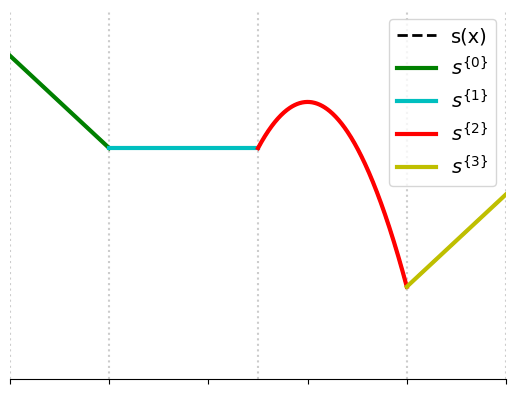

In [17]:
x=np.linspace(0, 5, 1000)

x1=np.linspace(0,1, 200)
x2=np.linspace(1,2.5,300)
x3=np.linspace(2.5,4,300)
x4=np.linspace(4,5,200)

Y_Piecewise=[]
for i in x:
    Y_Piecewise.append(PiecewiseExample(i))






fig,ax=plt.subplots()
#PlottenmitListen
#plt.plot(x,y,"g",label="f(x)",zorder=0.5)
plt.plot(x,Y_Piecewise,"k",label="s(x)",zorder=0.1, linestyle='dashed',linewidth=2)
plt.plot(x1,Piece1(x1),"g",label=r"$s^{\{0\}}$",zorder=1,linewidth=3)
plt.plot(x2,np.full((np.size(x2),), 1.25),"c",label=r"$s^{\{1\}}$",zorder=2,linewidth=3)
plt.plot(x3,Piece3(x3),"r",label=r"$s^{\{2\}}$",zorder=3,linewidth=3)
plt.plot(x4,Piece4(x4),"y",label=r"$s^{\{3\}}$",zorder=4,linewidth=3)


# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_xlim(0, 5)
ax.set_ylim(0, 2)
plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False)

plt.vlines([0, 1, 2.5, 4, 5], 0, 2.5, colors='0.8', linestyle='dotted', zorder=0)


#plt.xlabel("x")
#plt.ylabel("y")
plt.legend(prop={'size': 14})
#plt.savefig("Desktop/Slide6-6-plot.png", dpi=300, bbox_inches="tight")
plt.show()

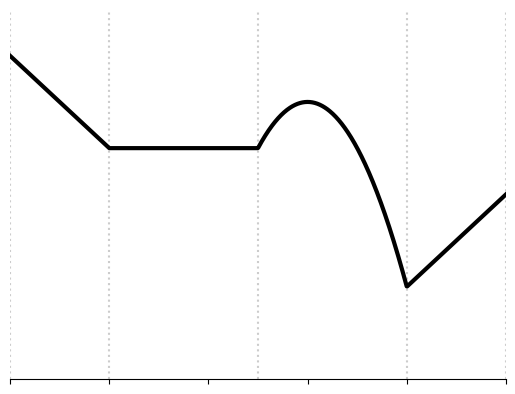

In [18]:
#This plot is not used in the final thesis.

x=np.linspace(0, 5, 1000)

Y_Piecewise=[]
for i in x:
    Y_Piecewise.append(PiecewiseExample(i))


fig,ax=plt.subplots()
plt.plot(x,Y_Piecewise,"k",label="s",zorder=0.1,linewidth=3)

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_xlim(0, 5)
ax.set_ylim(0, 2)
plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False)

plt.vlines([0, 1, 2.5, 4, 5], 0, 2.5, colors='0.8', linestyle='dotted', zorder=0)


#plt.xlabel("x")
#plt.ylabel("y")
#plt.savefig("Desktop/Slide8-plot.png", dpi=300, bbox_inches="tight")
plt.show()

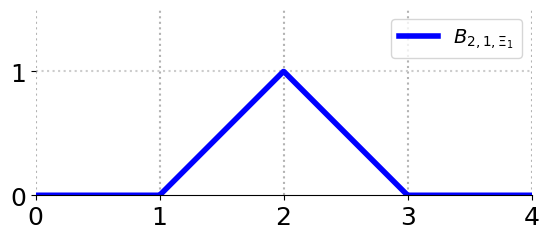

In [19]:
#This code only generates the left graph.
#Changes necessary to get the right graph
#will be pointed out.

Xi = np.array([0,1,2,3,4])
#right graph: Xi = np.array([1,2,3,3,3,3,3,3])
x=np.linspace(0, 4, 1000)

#BSplineRec does not accept arrays,
#so we need to use a loop
z=[]
for i in x:
    #right graph: BSplineRec(1, 1, Xi, i) instead
    z.append(BSplineRec(2, 1, Xi, i))

y=np.array(z)


fig,ax=plt.subplots()
#right graph: "r",label=r"$B_{1,1,\Xi_2}$"
plt.plot(x,z,"b",label=r"$B_{2,1,\Xi_1}$",zorder=0.1,linewidth=4)

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_xlim(0, 4)
ax.set_ylim(0, 1.5)
ax.set_xticks(np.arange(0, 5))
ax.set_yticks(np.array([0,1]))


plt.vlines([0, 1, 2, 3, 4], 0, 2.5, colors='0.7', linestyle='dotted', zorder=0)
plt.hlines([1], 0, 4, colors='0.8', linestyle='dotted', zorder=0)

plt.gca().set_aspect('equal')

plt.legend(prop={'size': 14})
#plt.savefig("Desktop/Slide17-plot.png", dpi=300, bbox_inches="tight")
plt.show()

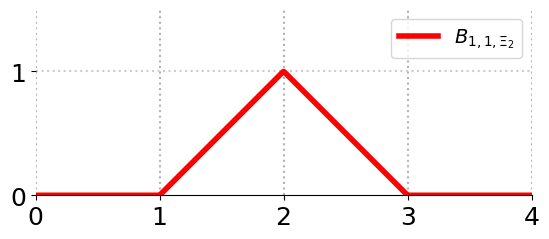

In [20]:
Xi = np.array([1,2,3,3,3,3,3,3])
x=np.linspace(0, 4, 1000)

#BSplineRec does not accept arrays,
#so we need to use a loop
z=[]
for i in x:
    z.append(BSplineRec(1, 1, Xi, i))

y=np.array(z)


fig,ax=plt.subplots()
plt.plot(x,z,"r",label=r"$B_{1,1,\Xi_2}$",zorder=0.1,linewidth=4)

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_xlim(0, 4)
ax.set_ylim(0, 1.5)
ax.set_xticks(np.arange(0, 5))
ax.set_yticks(np.array([0,1]))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 


plt.vlines([0, 1, 2, 3, 4], 0, 2.5, colors='0.7', linestyle='dotted', zorder=0)
plt.hlines([1], 0, 4, colors='0.8', linestyle='dotted', zorder=0)

plt.gca().set_aspect('equal')

plt.legend(prop={'size': 14})
#plt.savefig("Desktop/Slide17-plot2.png", dpi=300, bbox_inches="tight")
plt.show()

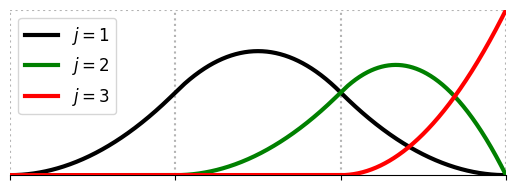

In [21]:
Xi = np.array([1,2,3,4,4,4])
x=np.linspace(1, 4, 1000, endpoint=False)


#BSplineRec does not accept arrays,
#so we need to use a loop
Y_dis=[]
Y_con=[]
Y_smooth=[]
for i in x:
    Y_dis.append(BSplineRec(1, 2, Xi, i))
    Y_con.append(BSplineRec(2, 2, Xi, i))
    Y_smooth.append(BSplineRec(3, 2, Xi, i))


fig,ax=plt.subplots()
plt.plot(x,Y_dis,"k",label=r"$j=1$",zorder=0.1, linewidth=3)
plt.plot(x,Y_con,"g",label=r"$j=2$",zorder=1, linewidth=3)
plt.plot(x,Y_smooth,"r",label=r"$j=3$",zorder=3, linewidth=3)


# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_xlim(1, 4)
ax.set_ylim(0, 1)
plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False)

#adds the dotted lines
plt.vlines([1, 2, 3, 4], 0, 2.5, colors='0.7', linestyle='dotted', zorder=0)
plt.hlines([1], 1, 4, colors='0.7', linestyle='dotted', zorder=0)

plt.gca().set_aspect('equal')

plt.legend(prop={'size': 12})
#plt.savefig("Desktop/Slide25-plot.png", dpi=300, bbox_inches="tight")
plt.show()

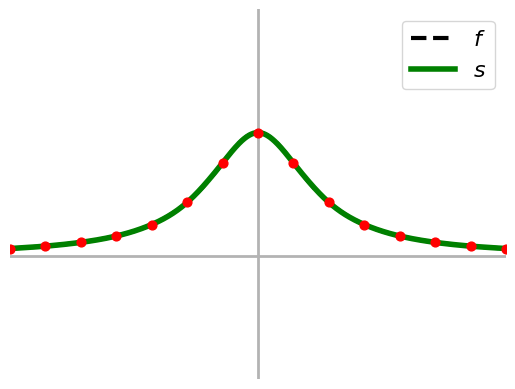

In [25]:
start=-2
end=2

#Setting n=5, 9, 15 yields the left, middle,
#and right plots, respectively.
n=5

#We will evaluate our functions at these points
#in order to plot them.
x=np.linspace(start, end, 1000, endpoint=True)

def f(x):
    return 1/(1+4*x**2)


#f does not accept arrays,
#so we need to use a loop
x_scatter=np.linspace(start,end,n,endpoint=True)
Y_scatter=[]
for i in x_scatter:
    Y_scatter.append(f(i))

#Calculating the coefficients of our piecewise
#polynomial in the B-Spline basis
c=CubicSplineCoeff(x_scatter, Y_scatter)

Y=[]
interp=[]
#These functions do not accept arrays as input,
#so we use a loop instead.
for i in x:
    interp.append(CubicSplineEval(x_scatter,c,i))
    Y.append(f(i))


fig,ax=plt.subplots()
plt.scatter(x_scatter,Y_scatter,c="r",s=40,zorder=2)
plt.plot(x,Y,"k",label=r"$f$",zorder=0.1, linestyle='dashed',linewidth=3)
plt.plot(x,interp,"g",label=r"$s$",zorder=1,linewidth=4)


#Hide all the spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.set_xlim(start, end)
ax.set_ylim(-1, 2)
plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False, bottom=False)

#adds x and y axes
plt.vlines([0], -20, 20, colors='0.7', zorder=0, linewidth=2)
plt.hlines([0], -20, 20, colors='0.7', zorder=0, linewidth=2)

plt.legend(prop={'size': 16})
#plt.savefig("Desktop/Slide33.png", dpi=300, bbox_inches="tight")
plt.show()